Author: Tyler Chase

Date: 2017/05/18

# Model NSFW Classification

This code uses an AlexNet model to classify an image as not safe for work (nsfw) or safe for work (sfw). 

## Load Datasets

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset, sample_data, plot_confusion_matrix
from model import Model, lazy_property
from config import ModelConfig, TrainConfig
from data_stats import DataStats
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

In [2]:
# Form training, developement, and testing data sets
address = r'/home/tylerchase/CS-231N-Final-Project/data/fullData//'
address = r'../../data/fullData//'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train subreddit labels shape: ', data.y_train.shape)
print('Train nsfw labels shape: ', data.y_train_2.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation subreddit labels shape: ', data.y_val.shape)
print('Validation nsfw labels shape: ', data.y_val_2.shape)
print('Test data shape: ', data.X_test.shape)
print('Test subreddit labels shape: ', data.y_test.shape)
print('Test nsfw labels shape: ', data.y_test_2.shape)

Train data shape:  (25450, 128, 128, 3)
Train subreddit labels shape:  (25450,)
Train nsfw labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation subreddit labels shape:  (3181,)
Validation nsfw labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test subreddit labels shape:  (3182,)
Test nsfw labels shape:  (3182,)


## Determine Subreddit Statistics of Data

In [ ]:
data_stats = DataStats(data, dictionary)
data_stats.sub_stats(dataSet = 'train')

In [ ]:
data_stats.sub_stats(dataSet = 'val')

## Determine NSFW Statistics of Data

In [ ]:
data_stats.nsfw_stats(dataSet = 'train')

In [ ]:
data_stats.nsfw_stats(dataSet = 'val')

## Determine NSFW Images Per Subreddit

In [ ]:
data_stats.subreddit_nsfw_stats(dataSet = 'train')

In [ ]:
data_stats.subreddit_nsfw_stats(dataSet = 'val')

## Optional Cell to take particular Subreddits from Dataset

Since safe for work SFW content takes up approximately 90% of the data here we balance the data by only considering 4 subreddits that are pictures of people. r/gonewild and r/ladybonersgw both contain mostly nsfw content and are women and men respectively. r/prettygirls and r/ladyboners both contain mostly sfw content and are women and men respectively.   

In [ ]:
subreddits = ['gonewild', 'ladybonersgw', 'PrettyGirls', 'LadyBoners']
dictionary_2 = sample_data(subreddits, data, dictionary)

## Check the Subreddit Statistics of the Data Subset

In [ ]:
data_stats = DataStats(data, dictionary_2)
data_stats.sub_stats(dataSet = 'train')

In [ ]:
data_stats.sub_stats(dataSet = 'val')

## Check the NSF Statistics

In [ ]:
data_stats.nsfw_stats(dataSet = 'train')

In [ ]:
data_stats.nsfw_stats(dataSet = 'val')

## Determine NSFW Images Per Subreddit

In [ ]:
data_stats.subreddit_nsfw_stats(dataSet = 'train')

In [ ]:
data_stats.subreddit_nsfw_stats(dataSet = 'val')

## Define AlexNet model 

* 11x11 convolutional layer with 96 filters and a stride of 4
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 5x5 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation
* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation 
* 3x3 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2


* affine layer from 4096 to 4096
* ReLU activation
* affine layer from 4096 to 4096
* ReLU activation
* affine layer from 4096 to 2

In [4]:
class AlexNet(Model):
    
    def __init__(self, model_config):
        Model.__init__(self, model_config)
  
    @lazy_property
    def prediction(self):
        # define our graph (e.g. AlexNet)
        
        a1 = tf.layers.conv2d(self.X_placeholder, filters=96, kernel_size=(11,11), strides=(4,4), padding='SAME') 
        h1 = tf.nn.relu(a1)
        mp1 = tf.layers.max_pooling2d(h1, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn1 = tf.layers.batch_normalization(mp1, training=self.is_training_placeholder)
        
        a2 = tf.layers.conv2d(bn1, filters=256, kernel_size=(5,5), strides=(1,1), padding='SAME')     
        h2 = tf.nn.relu(a2)
        mp2 = tf.layers.max_pooling2d(h2, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn2 = tf.layers.batch_normalization(mp2, training=self.is_training_placeholder)              
    
        a3 = tf.layers.conv2d(bn2, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h3 = tf.nn.relu(a3)
        a4 = tf.layers.conv2d(h3, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')   
        h4 = tf.nn.relu(a4)
        a5 = tf.layers.conv2d(h4, filters=256, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h5 = tf.nn.relu(a5)
        mp3 = tf.layers.max_pooling2d(h5, pool_size=(3,3), strides=(2,2), padding='SAME')  
    
        mp_flat = tf.reshape(mp3,[-1,4096])
        aff1 = tf.layers.dense(mp_flat, 4096)
        h6 = tf.nn.relu(aff1)
        aff2 = tf.layers.dense(h6, 4096)
        h7 = tf.nn.relu(aff2)
        y_out = tf.layers.dense(h7, self.config.nsfw_class_size)
    
        return y_out     

## Train the Model

In [5]:
# Create model instance
tf.reset_default_graph()

model_config = ModelConfig(learning_rate=0.003, output = 'nsfw')
train_config = TrainConfig(num_epochs=20, train_batch_size=100, print_every=100, lr_decay=0.98,\
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_nsfw_classification')
model = AlexNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

---------------------------------------------------------
Batch 100/255 of epoch 1 finished in 22.071638 seconds
Batch 200/255 of epoch 1 finished in 18.504949 seconds
Epoch 1 training finished in 52.399749 seconds
train accuracy:91.5%
val accuracy:92.0%
Epoch 1 evaluation finished in 28.353721 seconds
---------------------------------------------------------
Batch 100/255 of epoch 2 finished in 18.724201 seconds
Batch 200/255 of epoch 2 finished in 18.670653 seconds
Epoch 2 training finished in 47.592092 seconds
train accuracy:91.5%
val accuracy:92.0%
Epoch 2 evaluation finished in 14.938459 seconds
---------------------------------------------------------
Batch 100/255 of epoch 3 finished in 18.810408 seconds
Batch 200/255 of epoch 3 finished in 18.675644 seconds
Epoch 3 training finished in 47.695343 seconds
train accuracy:91.5%
val accuracy:92.0%
Epoch 3 evaluation finished in 14.906647 seconds
---------------------------------------------------------
Batch 100/255 of epoch 4 finis

## Return Loss and Accuracy History

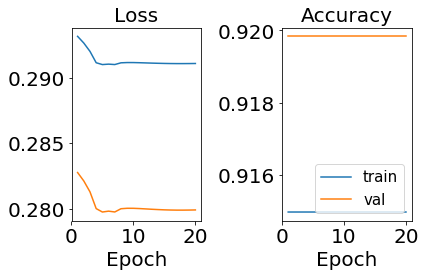

In [7]:
# Plot Loss and Accuracy
model.plot_loss_acc(data, save_address = '../../AlexNet_plots//', save_name = 'nsfw_history', \
    title_font = 20, tick_font = 20, legend_font = 15, axis_font = 20)

## Test Loading the Model

In [ ]:
# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(learning_rate=0.003, output = 'nsfw')
train_config = TrainConfig(num_epochs=2, minibatch_size=100, print_every=100, \
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_nsfw_classification')
model = AlexNet(model_config)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, train_config.saver_address + train_config.save_file_name) 

# Test Model Accuracy
loss_train, acc_train = model.eval(data, session, split='train')
loss_val, acc_val = model.eval(data, session, split = 'val')

print('Training Accuracy {:3.1f}%, Vallidation Accuracy:{:3.1f}%'.format((100*acc_train), (100*acc_val)))

## Output Predictions for Vallidation

In [8]:
y_val_pred = session.run(model.prediction, {model.X_placeholder: data.X_val, model.y_placeholder: data.y_val_2, 
                                            model.is_training_placeholder:False})

y_val_pred = np.argmax(y_val_pred, axis = 1)

## Plot Confusion Matrix for nsfw Classification

Normalized confusion matrix


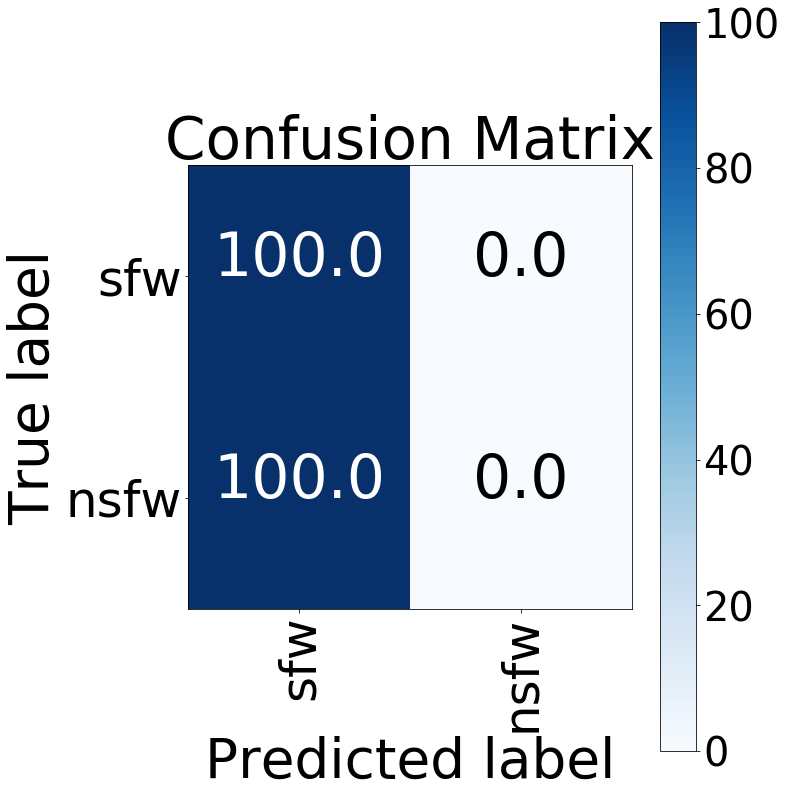

In [14]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_val_2, y_val_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True, figure_size = 11, tick_font = 50, box_font = 60, \
    axis_font = 55, title_font = 58, colorbar_font = 40,\
    left_space = 0.25, right_space = 0.95, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../AlexNet_plots//', save_name = 'nsfw_confusion_val')

## Outputs for Test

In [12]:
test_cost, test_acc = model.eval(data, session, "test")

y_test_pred = session.run(model.prediction, {model.X_placeholder: data.X_test, model.y_placeholder: data.y_test_2, 
                                            model.is_training_placeholder:False})

y_test_pred = np.argmax(y_test_pred, axis = 1)

test accuracy:90.9%


## Plot Confusion Matrix for NSFW test

Normalized confusion matrix


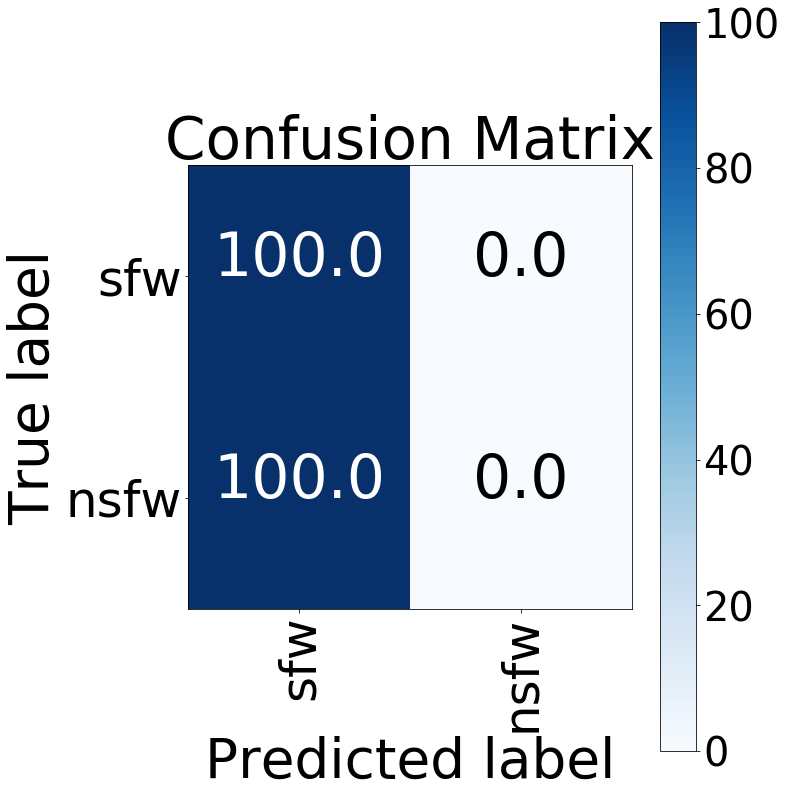

In [15]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_test_2, y_test_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True, figure_size = 11, tick_font = 50, box_font = 60, \
    axis_font = 55, title_font = 58, colorbar_font = 40,\
    left_space = 0.25, right_space = 0.95, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../AlexNet_plots//', save_name = 'nsfw_confusion_test')